In [5]:
import networkx  as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from backbone_disparity import disparity_filter


In [6]:
df = pd.read_pickle('../../Files/test_0613_cross.pickle')
ratio3 = pd.read_pickle('../../Files/test_0613_ratio_temp3.pickle')
ratio2 = pd.read_pickle('../../Files/test_0613_ratio_temp2.pickle')

In [7]:
df.head()

,subreddit,crosspost_parent,subreddit_subscribers,crosspost_parent_subs,count,crosspost_parent_num,total
0,6thForm,2meirl4meirl,35791.0,1268402,1,3,111
1,6thForm,6thForm,37984.0,37984,4,8,4
2,6thForm,Advice,37341.0,512881,1,1,11
3,6thForm,AlevelGeog,41873.0,159,1,1,1
4,6thForm,ApplyingToCollege,38328.5,325892,2,2,6


In [8]:
ratio = pd.concat([ratio3, ratio2])
ratio.head()

,subreddit,crosspost_parent,crosspost_child,total,crosspost_parent_%,crosspost_child_%
0,COVID19,3,69,7833,0.000383,0.008809
1,Coronavirus,2,87,8000,0.000250,0.010875
2,CovidVaccinated,21,127,8000,0.002625,0.015875
3,DebateVaccines,311,76,2580,0.120543,0.029457
4,HermanCainAward,15,0,42,0.357143,0.000000


# Graph & Backboning

In [25]:
G = nx.Graph()

In [26]:
t = df['subreddit'].drop_duplicates().to_list()
t.extend(df['crosspost_parent'].drop_duplicates().to_list())
res = []
for i in t:
    if i not in res:
        res.append(i)
G.add_nodes_from(res)

In [27]:
e = df[['subreddit', 'crosspost_parent', 'count']].values.tolist()

In [28]:
for u, v, weight in e:
    G.add_edge(u, v)
    G[u][v]['weight'] = weight

In [30]:
alpha = 0.05
G = disparity_filter(G)
G2 = nx.Graph([(u, v, d) for u, v, d in G.edges(data=True) if d['alpha'] < alpha])
print('alpha = %s' % alpha)
print('original: nodes = %s, edges = %s' % (G.number_of_nodes(), G.number_of_edges()))
print('backbone: nodes = %s, edges = %s' % (G2.number_of_nodes(), G2.number_of_edges()))



alpha = 0.05
original: nodes = 9354, edges = 28200
backbone: nodes = 839, edges = 1152


In [31]:
# get number of edges from graph
print(f'Nodes: {len(G.nodes)}, Edges: {len(G.edges)}')

Nodes: 9354, Edges: 28200


In [32]:
def degree_histogram_directed(G, in_degree=False, out_degree=False):

    nodes = G.nodes()
    if in_degree:
        in_degree = dict(G.in_degree())
        degseq=[in_degree.get(k,0) for k in nodes]
    elif out_degree:
        out_degree = dict(G.out_degree())
        degseq=[out_degree.get(k,0) for k in nodes]
    else:
        degseq=[v for k, v in G.degree()]
    dmax=max(degseq)+1
    freq= [ 0 for d in range(dmax) ]
    for d in degseq:
        freq[d] += 1
    return freq

Text(0, 0.5, 'Frequency')

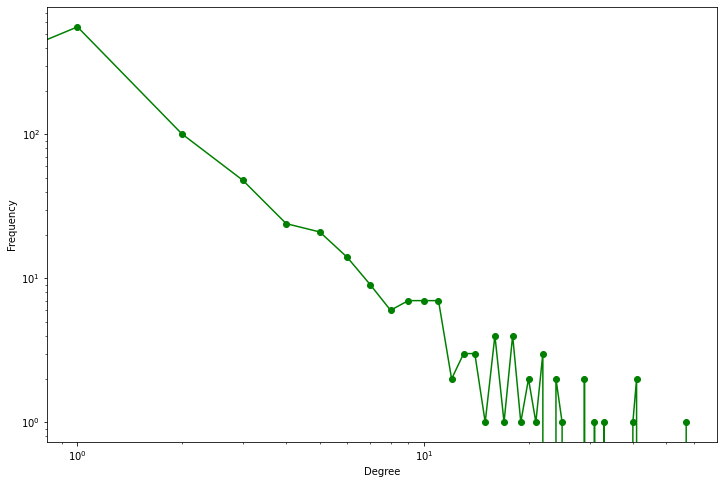

In [34]:
in_degree_freq = degree_histogram_directed(G2, )
# out_degree_freq = degree_histogram_directed(G2, out_degree=True)
degrees = range(len(in_degree_freq))
plt.figure(figsize=(12, 8)) 
plt.loglog(range(len(in_degree_freq)), in_degree_freq, 'go-', label='in-degree') 
# plt.loglog(range(len(out_degree_freq)), out_degree_freq, 'bo-', label='out-degree')
plt.xlabel('Degree')
plt.ylabel('Frequency')

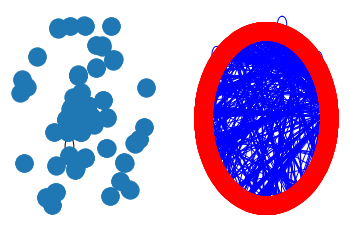

In [35]:
import matplotlib.pyplot as plt

subax1 = plt.subplot(121)
nx.draw(G2)   # default spring_layout
subax2 = plt.subplot(122)
nx.draw(G2, pos=nx.circular_layout(G2), node_color='r', edge_color='b')

In [39]:
# print(list(nx.connected_components(G2)))
print(nx.number_connected_components(G2))

38


In [40]:
for j in list(nx.connected_components(G2)):
    print(j)
    print(len(j))
    print('\n')

{'publix', 'theculling', 'vandwellers', 'Intelligence', 'RepublicanValues', 'WalmartCelebrities', 'WestVirginia', 'VeganLibs', 'Bad_Cop_No_Donut', 'FellowKids', 'myanmar', 'Nachrichten', 'AlternativeHistory', 'Wallstreetbetsnew', 'WinStupidPrizes', 'modernavaccine', 'SapphoAndHerFriend', 'Justfuckmyshitup', 'brasil', 'JoeBiden', 'Wallstreetsilver', 'Labour', 'PupliftingNews', 'AgainstTheIlluminati', 'BadGOP_NoDoughnuts', 'conservativecartoons', 'BabyBumps', 'halifax', 'KomradeInfo', 'ontario', 'australia', 'worldnewsvideo', 'WayOfTheBern', 'uspolitics', '196', 'stupidloopholes', 'HongKong', 'PublicFreakoutX', 'Boomerhumour', 'NotoQanon', '2meirl4meirl', 'ukpolitics', 'conspiracyfact', 'TikTokCringe', 'Mujico', 'stupidpol', 'Israel', 'BoycottChina', 'Makesmybloodboil', 'GetMotivated', 'onejob', 'CrimeMugshots', 'FridayNightFunkin', 'Wissenschaft', 'Africa', 'TheHealingEarth', 'Keep_Track', 'dontdeadopeninside', 'technicallythetruth', 'asia', 'StallmanWasRight', 'southafrica', 'blursedim

In [36]:
df2 = pd.DataFrame.from_dict(nx.degree_centrality(G2), orient='index', columns=['degree_centrality'])
df2 = df2.reset_index().rename(columns={'index': 'subreddit'})
df2['closeness_centrality'] = df2['subreddit'].map(nx.closeness_centrality(G2))
df2['degree'] = df2['subreddit'].map(G2.degree)

df2.head()

,subreddit,degree_centrality,closeness_centrality,degree
0,2meirl4meirl,0.001193,0.182771,1
1,aspiememes,0.039379,0.230555,33
2,PrequelMemes,0.002387,0.182977,2
3,sciencememes,0.004773,0.207315,4
4,dankmemes,0.013126,0.266148,11


In [37]:
df2.sort_values('degree_centrality',ascending=False).head()

,subreddit,degree_centrality,closeness_centrality,degree
10,JustUnsubbed,0.068019,0.262599,57
30,RuralNewsNetwork,0.048926,0.214925,41
5,ABoringDystopia,0.048926,0.274813,41
80,PublicFreakout,0.047733,0.270242,40
1,aspiememes,0.039379,0.230555,33


In [49]:
df2.to_csv('../../Files/subs_backboned.csv')

# Analysis

In [9]:
ratio.sort_values('crosspost_parent_%', ascending=False).head()

,subreddit,crosspost_parent,crosspost_child,total,crosspost_parent_%,crosspost_child_%
154,RimBob,39,0,39,1.000000,0.0
164,SurprisingNoOne,61,0,61,1.000000,0.0
291,patient_hackernews,6775,0,6781,0.999115,0.0
232,corruptscience,53,0,55,0.963636,0.0
168,TheFightThatMatters,1762,0,1852,0.951404,0.0


In [10]:
ratio.sort_values('crosspost_child_%', ascending=False).head()

,subreddit,crosspost_parent,crosspost_child,total,crosspost_parent_%,crosspost_child_%
182,TruthLeaks,148,280,1280,0.115625,0.218750
250,hackernews,0,1183,7743,0.000000,0.152783
3,ATBGE,29,1104,7739,0.003747,0.142654
215,blursedimages,1,1098,8000,0.000125,0.137250
79,EnrichYourJourney,5,1,8,0.625000,0.125000


In [11]:
df2 = pd.read_csv('../../Files/subs_backboned.csv')

In [12]:
df3 = df2.merge(ratio, left_on='subreddit', right_on='subreddit', how='left')

In [13]:
df3.drop(['Unnamed: 0'], axis=1, inplace=True)

In [14]:
len(df3)

839

In [15]:
df3.mean()

/var/folders/fh/yf9jwszj6d5_1_xhfz_l6k000000gn/T/ipykernel_53063/3891983329.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df3.mean()


degree_centrality          0.003277
closeness_centrality       0.166971
degree                     2.746126
crosspost_parent         414.850394
crosspost_child           54.724409
total                   5239.251969
crosspost_parent_%         0.145180
crosspost_child_%          0.010709
dtype: float64

In [16]:
df3['crosspost_parent'].isna().sum()

585

In [17]:
import praw

CLIENT_ID = '5FpjYNUrv93rDqflbNE-6w'
CLIENT_SECRET = '5ZITWnmNd6_qCbPXDB90xmOaIMo9_w'
USER_NAME = 'theonejay96'
SCRIPT_NAME = 'Data\ Science\ Thesis'
LOGIN_PASSWORD = 'vejkyz-hyBfez-4cinte'

reddit =  praw.Reddit(
    client_id= CLIENT_ID ,
    client_secret= CLIENT_SECRET ,
    user_agent= SCRIPT_NAME,
    username= USER_NAME,
    password= LOGIN_PASSWORD)


Version 7.5.0 of praw is outdated. Version 7.6.0 was released Tuesday May 10, 2022.


In [18]:
df3['subscribers'] = 0

In [19]:
from tqdm import tqdm
error = 0
for i, j in tqdm(df3.iterrows()):
    try:
        subreddit = reddit.subreddit(df3.loc[i]['subreddit'])
        df3.at[i,'subscribers'] = subreddit.subscribers
    except:
        error += 1
        continue

839it [09:43,  1.44it/s]


In [20]:
df3.head()

,subreddit,degree_centrality,closeness_centrality,degree,crosspost_parent,crosspost_child,total,crosspost_parent_%,crosspost_child_%,subscribers
0,2meirl4meirl,0.001193,0.182771,1,NaN,NaN,NaN,NaN,NaN,1392575
1,aspiememes,0.039379,0.230555,33,1987.0,29.0,5976.0,0.332497,0.004853,111039
2,PrequelMemes,0.002387,0.182977,2,NaN,NaN,NaN,NaN,NaN,2130955
3,sciencememes,0.004773,0.207315,4,310.0,6.0,2556.0,0.121283,0.002347,305576
4,dankmemes,0.013126,0.266148,11,0.0,56.0,8000.0,0.000000,0.007000,5765771


In [21]:

df4 = df3[df3['subscribers'] > 500000]

In [23]:
df4

,subreddit,degree_centrality,closeness_centrality,degree,crosspost_parent,crosspost_child,total,crosspost_parent_%,crosspost_child_%,subscribers
0,2meirl4meirl,0.001193,0.182771,1,NaN,NaN,NaN,NaN,NaN,1392575
2,PrequelMemes,0.002387,0.182977,2,NaN,NaN,NaN,NaN,NaN,2130955
4,dankmemes,0.013126,0.266148,11,0.0,56.0,8000.0,0.000000,0.007000,5765771
5,ABoringDystopia,0.048926,0.274813,41,2974.0,43.0,8000.0,0.371750,0.005375,730480
9,FuckYouKaren,0.021480,0.236168,18,1458.0,44.0,7779.0,0.187428,0.005656,1344481
...,...,...,...,...,...,...,...,...,...,...
751,ArtefactPorn,0.001193,0.197849,1,NaN,NaN,NaN,NaN,NaN,2527087
752,DataHoarder,0.001193,0.197849,1,NaN,NaN,NaN,NaN,NaN,631034
803,boston,0.001193,0.001193,1,NaN,NaN,NaN,NaN,NaN,544291
809,Filmmakers,0.003580,0.003580,3,149.0,18.0,7000.0,0.021286,0.002571,2654159


In [24]:
df3.to_csv('../../Files/subs_backboned_subscribers.csv')